In [14]:
# fetch input text
import urllib.request
url = 'https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt'
file_path = 'the-verdict.txt'
# urllib.request.urlretrieve(url, file_path)

with open('the-verdict.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()
print("Total number of character:", len(raw_text))
print(raw_text[:100])

Total number of character: 16384
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [15]:
# split text into tokens
import re
preprocessed = [item for item in re.split(r'([,.:;?_!"()\']|--|\s)', raw_text) if item.strip()]
print(len(preprocessed))
print(preprocessed[:30])

3702
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [16]:
# convert tokens into token IDs

# create vocabulary
all_words = sorted(list(set(preprocessed)))
vocab_size = len(all_words)
print(vocab_size)

vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i > 50:
        break
    

1013
('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Arrt', 15)
('As', 16)
('Be', 17)
('Burlington', 18)
('But', 19)
('By', 20)
('Carlo', 21)
('Chicago', 22)
('Claude', 23)
('Come', 24)
('Croft', 25)
('Destroyed', 26)
('Don', 27)
('Dubarry', 28)
('Emperors', 29)
('Florence', 30)
('For', 31)
('Gallery', 32)
('Gideon', 33)
('Gisburn', 34)
('Gisburns', 35)
('Grafton', 36)
('Grindle', 37)
('Grindles', 38)
('HAD', 39)
('Had', 40)
('Has', 41)
('He', 42)
('Her', 43)
('Hermia', 44)
('His', 45)
('How', 46)
('I', 47)
('If', 48)
('In', 49)
('It', 50)
('Jack', 51)


In [17]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {id:token for token,id in vocab.items()}
    
    def encode(self, text):
        preprocessed = [token.strip() for token in re.split(r'([,.:;?_!"()\']|--|\s)', text) if token.strip()]
        return [self.str_to_int[s] for s in preprocessed]
    
    def decode(self, ids):
        # "Hello , world !"  →  "Hello, world!"
        return re.sub(r'\s+([,.?!"()\'])', r'\1', " ".join([self.int_to_str[id] for id in ids]))

tokenizer = SimpleTokenizerV1(vocab)
text = 'I turned to Mrs. Gisburn, who had lingered to give a lump of sugar to her spaniel in the dining-room.'
print(tokenizer.decode(tokenizer.encode(text)) == text)


True


In [18]:

# add special token for vocabulary
all_tokens = all_words + ['<|endoftext|>', '<|unk|>']
vocab_size = len(all_tokens)
print(vocab_size)

vocab = {token:integer for integer,token in enumerate(all_tokens)}
for i, item in enumerate(vocab.items()):
    if i > len(vocab) - 5:
        print(item)

class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {id:token for token,id in vocab.items()}
    
    def encode(self, text):
        preprocessed = [token.strip() for token in re.split(r'([,.:;?_!"()\']|--|\s)', text) if token.strip()]
        preprocessed = [token if token in self.str_to_int else '<|unk|>' for token in preprocessed]
        return [self.str_to_int[s] for s in preprocessed]
    
    def decode(self, ids):
        # "Hello , world !"  →  "Hello, world!"
        return re.sub(r'\s+([,.?!"()\'])', r'\1', " ".join([self.int_to_str[id] for id in ids]))

tokenizer = SimpleTokenizerV2(vocab)
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

1015
('your', 1011)
('yourself', 1012)
('<|endoftext|>', 1013)
('<|unk|>', 1014)
Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1014, 5, 316, 1009, 562, 873, 10, 1013, 49, 883, 857, 880, 649, 883, 1014, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


In [19]:
from importlib.metadata import version
import tiktoken

print("tiktoken version:", version("tiktoken"))
tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)
strings = tokenizer.decode(integers)
print(strings)

tiktoken version: 0.9.0
[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


In [20]:
# data sampling with sliding window
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

enc_sample = enc_text[50:]
# context size determines how many tokens are included int the input
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y:      {y}")

# iterator all target
for i in range(1, context_size+1):
    context = enc_sample[:i]
    target = enc_sample[i]
    print(context, "---->", target)
print()
for i in range(1, context_size+1):
    context = enc_sample[:i]
    target = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([target]))

# data loader
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        tokens_id = tokenizer.encode(text)
        for i in range(0, len(tokens_id) - max_length, stride):
            input_chunk = tokens_id[i:i+max_length]
            output_chunk = tokens_id[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(output_chunk))
    
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(text, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(text, tokenizer, max_length, stride)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
     

4114
x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]
[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [21]:
# test dataloader
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)
second_batch = next(data_iter)
print(second_batch)
print()

dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("Targets:\n", targets)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [22]:
# token embeddings example
input_ids = torch.tensor([2, 3, 5, 1])
vocab_size = 6
output_dim = 3
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)
print(embedding_layer(torch.tensor([3])))
print(embedding_layer(input_ids))

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)
tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


In [23]:
# encoding word position
vocab_size = 50257
embed_dim = 256
# token embedding
token_emb = torch.nn.Embedding(vocab_size, embed_dim)
# load batch data
inputs, _ = next(iter(create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)))
token_vecs = token_emb(inputs)
print(token_vecs.shape)

# position embedding, max_length is 4, so it has '4' position
pos_emb = torch.nn.Embedding(4, embed_dim)
pos_vecs = pos_emb(torch.arange(4))
print(pos_vecs.shape)

# gpt input
input_embeds = token_vecs + pos_vecs

torch.Size([8, 4, 256])
torch.Size([4, 256])


In [24]:
import torch
# self-attention example
# 1.计算查询与每个输入之间的点积（注意力得分）；
# 2.使用 softmax 将得分归一化为权重；
# 3.按权重求输入向量的加权和，得到上下文向量。

# this is the embedding inputs
inputs = torch.tensor(
    [[0.43, 0.15, 0.89],  # Your    (x¹)
     [0.55, 0.87, 0.66],  # journey (x²)
     [0.57, 0.85, 0.64],  # starts  (x³)
     [0.22, 0.58, 0.33],  # with    (x⁴)
     [0.77, 0.25, 0.10],  # one     (x⁵)
     [0.05, 0.80, 0.55]]  # step    (x⁶)
)
# the first step is to calculate the **attention scores** between the query token and each input token
# calculate the attention score of x2
query = inputs[1]
attention_scores_2 = torch.empty(inputs.shape[0])
for i,x_i in enumerate(inputs):
    attention_scores_2[i] = torch.dot(query, x_i)
print(attention_scores_2)
# normalize the score
attention_weights_2_tmp = attention_scores_2 / attention_scores_2.sum()
print("Attention weight:", attention_weights_2_tmp)
print("Sum:", attention_weights_2_tmp.sum())
# use softmax to normalize
atention_weights_2 = torch.softmax(attention_scores_2, dim=0)
print("Attention weight:", atention_weights_2)
print("Sum:", atention_weights_2.sum())
# calculate the context vector
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += atention_weights_2[i] * x_i
print("Context vec:", context_vec_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Attention weight: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)
Attention weight: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Context vec: tensor([0.4419, 0.6515, 0.5683])


In [25]:
# calculate the attention weights for all input tokens
attention_scores = torch.empty(6, 6)
for i,x_i in enumerate(inputs):
    for j,x_j in enumerate(inputs):
        attention_scores[i, j] = torch.dot(x_i, x_j)
print(attention_scores)

attention_scores = inputs @ inputs.T
print(attention_scores)
# normalize the scores
attention_weights = torch.softmax(attention_scores, dim=-1)
print(attention_weights.sum(dim=-1))
# context vec
all_context_vecs = attention_weights @ inputs
print(all_context_vecs)
print("Previous 2nd context vec:", context_vec_2)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])
Previous 2nd context vec: tensor([0.4419

## self-attention with trainable weight

In [26]:

# use Wq,Wk,Wv
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2 # for example
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out, requires_grad=False))
W_value = torch.nn.Parameter(torch.rand(d_in, d_out, requires_grad=False))
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)
print(W_query.shape)
# all inputs
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

# attention score for x2
keys_2 = keys[1]
attention_score22 = query_2.dot(keys_2)
print(attention_score22)
# all attention scores for give query 2
attention_scores_2 = query_2 @ keys.T
print(attention_scores_2)
# scale
d_k = keys.shape[-1]
attention_weights_2 = torch.softmax(attention_scores_2 / d_k**0.5, dim=-1)
print(attention_weights_2)
# context vec
context_vec_2 = attention_weights_2 @ values
print(context_vec_2)

tensor([0.4306, 1.4551])
torch.Size([3, 2])
keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])
tensor(1.8524, grad_fn=<DotBackward0>)
tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
       grad_fn=<SqueezeBackward4>)
tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820],
       grad_fn=<SoftmaxBackward0>)
tensor([0.3061, 0.8210], grad_fn=<SqueezeBackward4>)


In [27]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        queries = x @ self.W_query
        keys = x @ self.W_key
        values = x @ self.W_value

        attention_scores = queries @ keys.T
        attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim=-1)
        context_vecs = attention_weights @ values
        return context_vecs

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))


tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [28]:
# use nn.Linear
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        attention_scores = queries @ keys.T
        attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim=-1)
        context_vecs = attention_weights @ values
        return context_vecs

torch.manual_seed(123)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)


## Hide future words with causal attention

In [29]:
# 注意力矩阵主对角线之上的「未来词元」对应的权重全部遮蔽（置为 -∞），然后仅对未被遮蔽的权重做 softmax 归一化，使得每一行有效权重之和为 1
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attention_scores = queries @ keys.T
attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim= -1)
print(attention_weights)
# create a mask where the values above the diagonal are zero
context_length = attention_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length), diagonal=0)
print(mask_simple)
mask_simple = attention_weights * mask_simple
print(mask_simple)
row_sums = mask_simple.sum(dim=-1, keepdim=True)
mask_simple_normalize = mask_simple / row_sums
# print(mask_simple_normalize)

# another method to mask attention weights
# 对角线以上全为1
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attention_scores.masked_fill(mask.bool(), -torch.inf)
# print(masked)
attention_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attention_weights)
context_vec = attention_weights @ values
print(context_vec)

tensor([[0.1717, 0.1762, 0.1761, 0.1555, 0.1627, 0.1579],
        [0.1636, 0.1749, 0.1746, 0.1612, 0.1605, 0.1652],
        [0.1637, 0.1749, 0.1746, 0.1611, 0.1606, 0.1651],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.1632, 0.1674],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.1639],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])
tensor([[0.1717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1749, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1637, 0.1749, 0.1746, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.0000, 0.0000],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<MulBackward0>)
tensor([[1.0000, 0.0000, 0.0000

In [30]:
# Masking additional attention weights with dropout
torch.manual_seed(123)
drop_out = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(drop_out(example))
print(drop_out(attention_weights))
# test batch inputs
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])
tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6816, 0.6804, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5085, 0.4936, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3906, 0.0000],
        [0.3249, 0.3418, 0.0000, 0.3308, 0.3249, 0.3363]],
       grad_fn=<MulBackward0>)
torch.Size([2, 6, 3])


In [31]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, drop_out, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(drop_out)

        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, x):
        b, num_tokens, _ = x.shape
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # here we think about the batch dim: ->(b, d_out, num_tokens)
        attention_scores = queries @ keys.transpose(1, 2)
        attention_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim=-1)
        attention_weights = self.dropout(attention_weights)
        context_vecs = attention_weights @ values
        return context_vecs

torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, drop_out=0.0)
context_vecs = ca(batch)
print("context_vecs.shape", context_vecs.shape)

context_vecs.shape torch.Size([2, 6, 2])


## Extending single-head attention to multi-head attention

### Stacking multiple single-head attention layers

In [32]:
# stack CausalAttention
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, drop_out, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList([CausalAttention(d_in, d_out, context_length, drop_out, qkv_bias) for _ in range(num_heads)])
    
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

torch.manual_seed(123)
context_length = batch.shape[1]
d_in,d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


### Implementing multi-head attention with weight splits

In [41]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, drop_out, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisiable by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # why we need a output projection?
        self.out_proj = nn.Linear(d_out, d_out)
        self.drop_out = nn.Dropout(drop_out)

        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        # x:(batch, num_tokens, d_in)
        b, num_tokens, d_in = x.shape

        # q:(batch, num_tokens, d_out)
        q = self.W_query(x)
        k = self.W_key(x)
        v = self.W_value(x)


        # view:(batch, heads, num_tokens, head_dim)
        q = q.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)


        # attention_scores:(batch, heads, num_tokens, num_tokens)
        attention_scores = q @ k.transpose(2, 3)
        attention_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)

        attention_weights = torch.softmax(attention_scores / k.shape[-1]**0.5, dim=-1)
        attention_weights = self.drop_out(attention_weights)

        # context_vecs:(batch, num_tokens, heads, head_dim)
        context_vecs = (attention_weights @ v).transpose(1, 2)
        context_vecs = context_vecs.contiguous().view(b, num_tokens, self.d_out)
        context_vecs = self.out_proj(context_vecs)
        return context_vecs

torch.manual_seed(123)
batch_size, context_len, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_len, drop_out=0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print(context_vecs.shape)

ValueError: not enough values to unpack (expected 3, got 2)

# GPT
## LLM architecture


In [34]:
import torch
import torch.nn as nn


GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x
    
class DummyLinearNorm(nn.Module):
    def __init__(self, normalized_dim, eps=1e-5):
        super().__init__()
    
    def forward(self, x):
        return x
    

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg["vocab_sizes"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emd_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = DummyLinearNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        token_emb = self.token_emb(in_idx)
        pos_emb = self.pos_emb(torch.arange(seq_len))
        x = token_emb + pos_emb
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch = torch.stack([torch.tensor(tokenizer.encode(txt1)), torch.tensor(tokenizer.encode(txt2))], dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [35]:
## Layer Normalization

torch.manual_seed(123)
example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(example)
# print(out)
mean = out.mean(dim=-1, keepdim=True)
# print(mean)
var = out.var(dim=-1, keepdim=True)
# print(var)
out_norm = (out - mean) / torch.sqrt(var)
print(out_norm)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
# print(mean)
# print(var)

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        return self.scale * (x - mean) / (torch.sqrt(var + self.eps)) + self.shift
    
ln = LayerNorm(emb_dim=5)
out_ln = ln(example)
print(out_ln.mean(), out_ln.var())

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
tensor(-4.7684e-08, grad_fn=<MeanBackward0>) tensor(1.1111, grad_fn=<VarBackward0>)


## Feed forward network with GELU activation

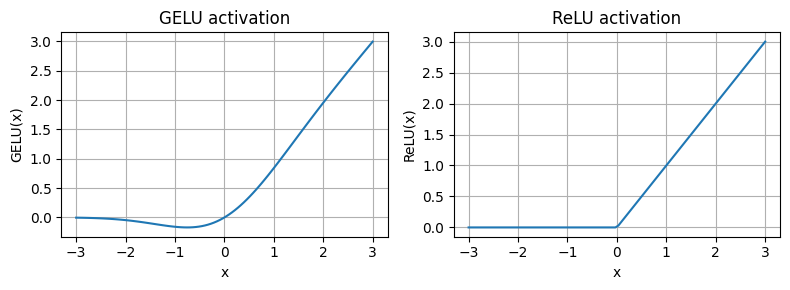

In [36]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3))
        ))

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    # 将张量转成列表，避免调用 .numpy()
    plt.plot(x.tolist(), y.tolist())
    plt.title(f"{label} activation")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# (批, 令牌数, 768)
#       │  Linear 768→3072
#       ▼
# (批, 令牌数, 3072)
#       │  GELU
#       ▼
# (批, 令牌数, 3072)
#       │  Linear 3072→768
#       ▼
# (批, 令牌数, 768)
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    def forward(self, x):
        return self.layers(x)
    
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## Shortcut connections
将输入再次加到该层的输出，缓解梯度衰减

In [38]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_size, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        # five "Linear -> GELU"
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_size[0], layer_size[1]), GELU()),
            nn.Sequential(nn.Linear(layer_size[1], layer_size[2]), GELU()),
            nn.Sequential(nn.Linear(layer_size[2], layer_size[3]), GELU()),
            nn.Sequential(nn.Linear(layer_size[3], layer_size[4]), GELU()),
            nn.Sequential(nn.Linear(layer_size[4], layer_size[5]), GELU()),
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()(output, target)
    loss.backward()
    for name, param in model.named_parameters():
        # print(name) #`layers.0.0.bias` and `layers.1.0.weight`
        # print(param.shape)
        if "weight" in name:
            g_mean = param.grad.abs().mean().item()
            print(f"{name}'s grad mean: {g_mean:.4f}")

layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_no_short = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)
print("Without shortcut:")
print_gradients(model_no_short, sample_input)

model_no_short = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print("With shortcut:")
print_gradients(model_no_short, sample_input)

Without shortcut:
layers.0.0.weight's grad mean: 0.0002
layers.1.0.weight's grad mean: 0.0001
layers.2.0.weight's grad mean: 0.0007
layers.3.0.weight's grad mean: 0.0014
layers.4.0.weight's grad mean: 0.0050
With shortcut:
layers.0.0.weight's grad mean: 0.0014
layers.1.0.weight's grad mean: 0.0048
layers.2.0.weight's grad mean: 0.0041
layers.3.0.weight's grad mean: 0.0059
layers.4.0.weight's grad mean: 0.0327


## Connection attention and linear in a transformer block
![connect_attention_linear](connect_attention_linear.png)

In [42]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            drop_out=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        # Linear -> GELU -> Linear
        self.ff = FeedForward(cfg)

        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])

        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # self attention
        shortcut_x = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut_x

        # feed forward
        shortcut_x = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut_x
        return x
    
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
out = block(x)
print("Input shape:", x.shape)
print("Output shape:", out.shape)

        


torch.Size([2, 4, 768])
torch.Size([2, 4, 768])


## GPT model

![GPT](gpt.png)

In [64]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_out = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_layer_norm = LayerNorm(cfg["emb_dim"])
        self.output_layer = nn.Linear(cfg["emb_dim"], cfg["vocab_size"])
    
    def forward(self, x):
        batch, context_length = x.shape
        token_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(torch.arange(context_length))
        
        x = token_emb + pos_emb
        x = self.drop_out(x)
        x = self.trf_blocks(x)
        x = self.final_layer_norm(x)
        x = self.output_layer(x)
        return x
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out.max(dim=-1))
total_params = sum([p.numel() for p in model.parameters()])
print("parameters:", total_params)
print(model.tok_emb.weight.shape)
print(model.pos_emb.weight.shape)

total_params_gpt2 = total_params - sum([p.numel() for p in model.output_layer.parameters()])

print("Number of trainable parameters:", total_params_gpt2)

total_size_bytes = total_params * 4        # 32-bit float ⇒ 4 B
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
torch.return_types.max(
values=tensor([[2.6121, 2.5646, 2.3975, 2.3694],
        [2.3718, 2.9749, 2.7942, 2.4123]], grad_fn=<MaxBackward0>),
indices=tensor([[ 2215, 36230, 49103, 37532],
        [40412, 30882, 46430, 29873]]))
parameters: 163059793
torch.Size([50257, 768])
torch.Size([1024, 768])
Number of trainable parameters: 124412160
Total size of the model: 622.02 MB


## Generate text